# Analysis of scRNA-seq data from steady state B cells 

In CVID and healthy control, Smart-seq2 platform

Notebook organisation:
- 1: standard unbiased analysis with scanpy
- 2: DE analysis with limma

In [1]:
import numpy as np
import scrublet as scr
import pandas as pd
import seaborn as sns
import scanpy as sc
from glob import iglob
import anndata
import scipy
import bbknn
import os
import sklearn
import matplotlib.pyplot as plt

In [2]:
np.random.seed(0)

In [3]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './figures/' # specifying output directory for figures
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.2
anndata             0.7.5
annoy               NA
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
bbknn               NA
brotli              NA
cairo               1.20.0
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.03.1
dateutil            2.8.1
decorator           4.4.2
fsspec              0.8.7
get_version         2.1
google              NA
h5py                3.1.0
idna                2.10
igraph              0.8.3
ipykernel           5.5.0
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.4.1
jupyte

### Declaring doublet calling functions

In [4]:
def bh(pvalues):
    '''
    Computes the Benjamini-Hochberg FDR correction.
    
    Input:
        * pvals - vector of p-values to correct
    '''
    n = int(pvalues.shape[0])
    new_pvalues = np.empty(n)
    values = [ (pvalue, i) for i, pvalue in enumerate(pvalues) ]
    values.sort()
    values.reverse()
    new_values = []
    for i, vals in enumerate(values):
        rank = n - i
        pvalue, index = vals
        new_values.append((n/rank) * pvalue)
    for i in range(0, int(n)-1):
        if new_values[i] < new_values[i+1]:
            new_values[i+1] = new_values[i]
    for i, vals in enumerate(values):
        pvalue, index = vals
        new_pvalues[index] = new_values[i]
    return new_pvalues

In [5]:
###################
# doublet calling #
###################

def bertie(adata_sample, sample):
    
    scorenames = ['scrublet_score','scrublet_cluster_score','bh_pval']
    
    adata_sample_copy = adata_sample.copy()
    # set up and run Scrublet
    scrub = scr.Scrublet(adata_sample_copy.X)
    doublet_scores, predicted_doublets = scrub.scrub_doublets(verbose=False)
    adata_sample_copy.obs['scrublet_score'] = doublet_scores
    
    # overcluster prep. run turbo basic scanpy pipeline
    sc.pp.normalize_per_cell(adata_sample_copy, counts_per_cell_after=1e4)
    sc.pp.log1p(adata_sample_copy)
    sc.pp.highly_variable_genes(adata_sample_copy, min_mean=0.0125, max_mean=3, min_disp=0.5)
    adata_sample_copy = adata_sample_copy[:, adata_sample_copy.var['highly_variable']]
    adata_sample_copy = adata_sample_copy.copy()
    sc.pp.scale(adata_sample_copy, max_value=10)
    sc.tl.pca(adata_sample_copy, svd_solver='arpack')
    sc.pp.neighbors(adata_sample_copy)
    
    # overclustering proper - do basic clustering first, then cluster each cluster
    sc.tl.louvain(adata_sample_copy)
    for clus in np.unique(adata_sample_copy.obs['louvain']):
        sc.tl.louvain(adata_sample_copy, restrict_to=('louvain',[clus]))
        adata_sample_copy.obs['louvain'] = adata_sample_copy.obs['louvain_R']
        
    # compute the cluster scores - the median of Scrublet scores per overclustered cluster
    for clus in np.unique(adata_sample_copy.obs['louvain']):
        adata_sample_copy.obs.loc[adata_sample_copy.obs['louvain']==clus, 'scrublet_cluster_score'] = \
            np.median(adata_sample_copy.obs.loc[adata_sample_copy.obs['louvain']==clus, 'scrublet_score'])
        
    # now compute doublet p-values. figure out the median and mad (from above-median values) for the distribution
    med = np.median(adata_sample_copy.obs['scrublet_cluster_score'])
    mask = adata_sample_copy.obs['scrublet_cluster_score']>med
    mad = np.median(adata_sample_copy.obs['scrublet_cluster_score'][mask]-med)
    
    #let's do a one-sided test. the Bertie write-up does not address this but it makes sense
    pvals = 1-scipy.stats.norm.cdf(adata_sample_copy.obs['scrublet_cluster_score'], loc=med, scale=1.4826*mad)
    adata_sample_copy.obs['bh_pval'] = bh(pvals)
    
    # getting calculated values to the initial object with raw count values
    for col in scorenames:
        adata_sample.obs[col] = adata_sample_copy.obs[col]
    
    return adata_sample.obs[scorenames]

## Reading and preprocessing

In [6]:
runlanes = ['24057_6','24057_7','24224_1','24130_7']

Prepare gene translator (ENSG to HGNC-like, these are gene codes in different systems) and plate/position metadata structures (file with metadata information I guess). Create the meta parsing at a deep level of abstraction - a dictionary with a `regexp` field to match against the cell names and a `translate` field to then take the match and cough up the appropriate metadata. Remember that the match will be a string, so just in case ensure that all dictionary keys are strings too.

Whereas you don't get sed's cool parentheses functionality, you can emulate it to some degree with assertions:
* `(?=)` is a **lookahead assertion**, matching the pattern that comes in the parentheses after the equal sign, requiring it appear after a match, but not including it in the reported match.
* `(?<=)` is a **lookbehind assertion**, matching the pattern that comes in the parentheses after the equal sign, requiring it appear before a match, but not including it in the reported match.

This behavious can also be turned into **negative assertions** by using a `!` instead of a `=`. In the interest of clarity, the regular expressions are written out to have the lookaheads/lookbehinds clearly split from the main pattern via pasting.

In [7]:
#soak up barcodes.tsv for a cheeky recreation of cellranger names - ???
import re
genetrans = {}

path = '/home/jovyan/notebooks/Vento_Lab/CVID/old_analysis_first_submission/GitHub_to_post/CVID_old_full/scTranscriptomics/steady_state_SS2_data/'

with open(path + 'genes.tsv','r') as fid:    # just ordinarily reading a file
    for line in fid:
        genetrans[line.strip().split()[0]] = line.strip().split()[1]

#import plate metadata
meta = pd.read_csv(path + 'meta.csv',index_col=0)
#print(meta)
meta = meta.to_dict()
for key in meta:
    #print('key', key)
    #metahold = meta.pop(key)
    metahold = meta[key]
    #print('metahold 1', metahold)
    #convert keys to string as regexp matches are strings, even if the contents are ints
    metahold = {str(k):v for k,v in metahold.items()}
    #print('metahold 2', metahold)
    meta[key] = {}
    #(?<=) matches before pattern, (?=) matches after pattern
    #here we require a '-' before our pattern and a '_' after it
    meta[key]['regexp'] = re.compile('(?<=-)'+'[0-9]+'+'(?=_)')
    meta[key]['translate'] = metahold
#columns go in fours and each is a different cell type
meta['celltype'] = {}
meta['celltype']['regexp'] = re.compile('(?<=[A-H])'+'[0-9]+'+'$')
meta['celltype']['translate'] = {}
meta['celltype']['translate'].update(zip([str(i).zfill(2) for i in np.arange(1,5)],['N']*4))
meta['celltype']['translate'].update(zip([str(i).zfill(2) for i in np.arange(5,9)],['USM']*4))
meta['celltype']['translate'].update(zip([str(i).zfill(2) for i in np.arange(9,13)],['SM']*4))

In the next cell below:
- read the raw file (output of cellranger)
- do step 1 of calling doublets according to bertie doublet caller and adding all the scores 
- Add %mt genes
- Add relevant annotation info

Later after looking at QC:
- Filter: a) cells (< 200 genes); b) genes (< 3 cells);

In [8]:
meta.keys()

dict_keys(['batchcode', 'treatment', 'celltype'])

In [9]:
%%time

holder = []

scorenames = ['scrublet_score','scrublet_cluster_score','bh_pval']

runlanes = list(runlanes)

for lane in runlanes:
    print('lane',lane, list(runlanes).index(lane)+1,'out of',len(runlanes))
    path_total = path + lane + '/countMatrixNames.txt'
    # import data
    holder.append(sc.read_text(path_total).T)
    
    #translate gene names to HGNC-like
    genehold = list(holder[-1].var_names)
    for i in range(len(genehold)):
        genehold[i] = genetrans[genehold[i]]
        
    holder[-1].var_names = genehold
    holder[-1].var_names_make_unique()
    
    # prepare plate/well related metadata
    for key in meta:
        print('key',key)
        metahold = []
        for ind in holder[-1].obs.index:
            #print('ind', ind)
            #print('meta[key]',meta[key])
            #print(meta[key]['regexp'].search(ind).group())
            #get the match of meta[key]['regexp'] on the index
            #and then use that as a key for meta[key]['translate'] to get the actual metadata
            # had to add another 'translate' here because of Krzysztof's dictionary structure
            if key == 'celltype':
                metahold.append(meta[key]['translate'][meta[key]['regexp'].search(ind).group()])
            else:
                metahold.append(meta[key]['translate'][meta[key]['regexp'].search(ind).group()])
        holder[-1].obs[key] = metahold
    
    
    # Filer cells with less than 200 genes expressed
    sc.pp.filter_cells(holder[-1], min_genes=200)
    
    # Filer genes expressed in less than 3 cells
    sc.pp.filter_genes(holder[-1], min_cells=3)
    
    # Sample information
    holder[-1].obs['lane'] = lane
    
    # Extract mitochondial genes
    mito_genes = [name for name in holder[-1].var_names if name.startswith('MT-')]
    #for each cell compute fraction of counts in mito genes vs. all genes
    #the `.A1` is only necessary, as X is sparse - it transform to a dense array after summing
    holder[-1].obs['percent_mito'] = np.sum(
        holder[-1][:, mito_genes].X, axis=1) / np.sum(holder[-1].X, axis=1)
    
    #add the total counts per cell as observations-annotation to adata
    holder[-1].obs['n_counts'] = holder[-1].X.sum(axis=1)
    
    # calling doublets on current sample's adata which is holder[-1]
    print('going on to call doublets (write doublet scores into tables) with bertie')
    scores_table = bertie(holder[-1], lane)
    if list(scores_table.index) == list(holder[-1].obs.index):
        print('indices in current bertie table and sample adata are matching, assigning scores')
        for meta_name in scorenames:
            holder[-1].obs[meta_name] = scores_table[meta_name]
    else:
        print('indices in current bertie table and sample adata are NOT matching')
    


lane 24057_6 1 out of 4


filtered out 38 cells that have less than 200 genes expressed
filtered out 17807 genes that are detected in less than 3 cells


key batchcode
key treatment
key celltype
going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 5 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 10 clus

indices in current bertie table and sample adata are matching, assigning scores
lane 24057_7 2 out of 4


filtered out 27 cells that have less than 200 genes expressed
filtered out 15432 genes that are detected in less than 3 cells


key batchcode
key treatment
key celltype
going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 6 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 10 clus

indices in current bertie table and sample adata are matching, assigning scores
lane 24224_1 3 out of 4


filtered out 57 cells that have less than 200 genes expressed
filtered out 20357 genes that are detected in less than 3 cells


key batchcode
key treatment
key celltype
going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 5 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 11 clus

indices in current bertie table and sample adata are matching, assigning scores
lane 24130_7 4 out of 4


filtered out 65 cells that have less than 200 genes expressed
filtered out 16043 genes that are detected in less than 3 cells


key batchcode
key treatment
key celltype
going on to call doublets (write doublet scores into tables) with bertie


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 5 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 9 clust

indices in current bertie table and sample adata are matching, assigning scores
CPU times: user 47.2 s, sys: 43.9 s, total: 1min 31s
Wall time: 19.2 s


# QC and cutoff decisions

In [50]:
# concatenate all samples into 1 object
adata = holder[0].concatenate(holder[1:],join='outer',index_unique=None)

In [51]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)


/opt/conda/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [52]:
# median of detected genes
np.median(adata.obs['n_genes'])

1598.0

... storing 'batchcode' as categorical
... storing 'treatment' as categorical
... storing 'celltype' as categorical
... storing 'lane' as categorical


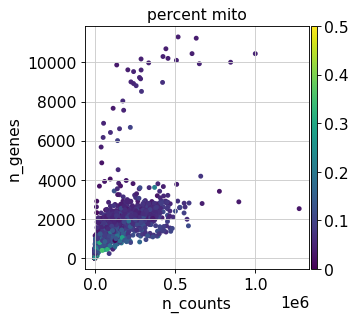

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


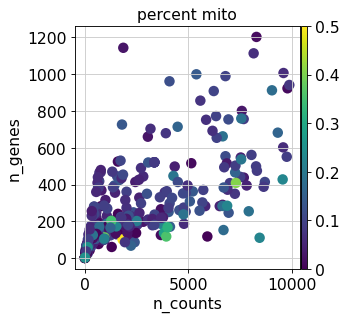

In [53]:
#Data quality summary plots
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='percent_mito')
p2 = sc.pl.scatter(adata[adata.obs['n_counts']<10000], 'n_counts', 'n_genes', color='percent_mito')


/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


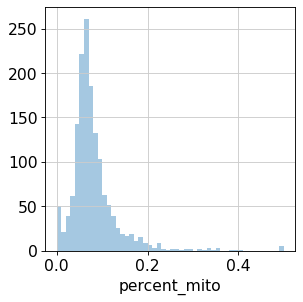

In [54]:
p3 = sns.distplot(adata.obs['percent_mito'], kde=False)
plt.show()

In [55]:
np.percentile(list(adata.obs['percent_mito']),20)

nan

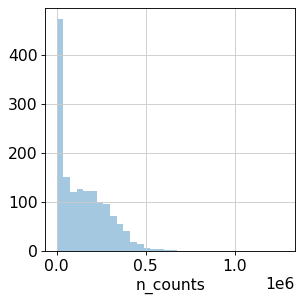

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


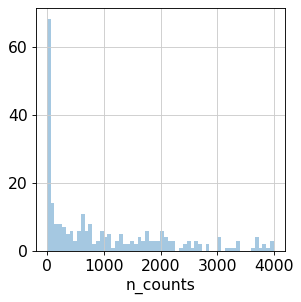

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


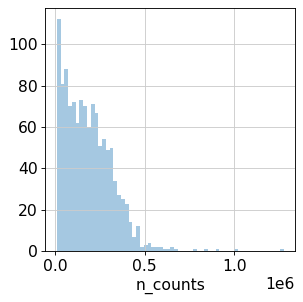

In [56]:
# Thresholding decision: counts
p3 = sns.distplot(adata.obs['n_counts'], kde=False)
plt.show()

p4 = sns.distplot(adata.obs['n_counts'][adata.obs['n_counts']<4000], kde=False, bins=60)
plt.show()

p5 = sns.distplot(adata.obs['n_counts'][adata.obs['n_counts']>10000], kde=False, bins=60)
plt.show()


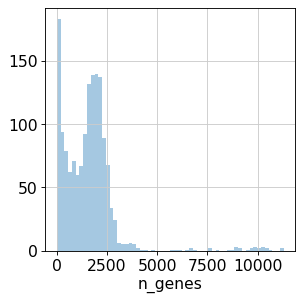

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


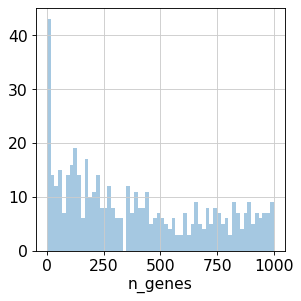

In [57]:
# Thresholding decision: genes
p6 = sns.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

p7 = sns.distplot(adata.obs['n_genes'][adata.obs['n_genes']<1000], kde=False, bins=60)
plt.show()

**Desicion**: gene cutoff: min_genes=200, min_cells=3, going back up and filter there

__________________________________________________________________________________________________

After rerunning the reading cell in the beginning carrying on to:
- Concatenate
- Normalise
- Log-transform

In [10]:
%%time

adata = holder[0].concatenate(holder[1:],join='outer',index_unique=None)
adata.X[np.isnan(adata.X)] = 0

# normalise and log transform
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

normalizing by total count per cell
/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


CPU times: user 584 ms, sys: 80.6 ms, total: 665 ms
Wall time: 662 ms


______________

Carrying on to 
- Filter MT-high cells (>20%)
- Save raw attribute
- Make cell names (obs) and gene names (var) unique

In [11]:
# mt % filtering
adata = adata[adata.obs['percent_mito'] < 0.2]

# saving the raw attribute
adata.raw = adata.copy()

adata.var_names_make_unique()
adata.obs_names_make_unique()


/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [12]:
# adding 'is_doublet' annotation by throsholding the bh_pvalue, this is not the end of doublet calling
adata.obs['is_doublet'] = adata.obs['bh_pval'] < 0.1

In [13]:
%%bash 

pwd

/home/jovyan/notebooks/Vento_Lab/CVID/202009_new_analysis_revision/CITE_all_samples_analysis/CVID/202003_initial_analysis_scTranscriptomics/scTranscriptomics


In [14]:
adata.write('/home/jovyan/notebooks/Vento_Lab/CVID/202009_new_analysis_revision/CITE_all_samples_analysis/CVID/202003_initial_analysis_scTranscriptomics/scTranscriptomics/adata_objects/adata_SS2_proc_20210419.h5ad')


... storing 'batchcode' as categorical
... storing 'treatment' as categorical
... storing 'celltype' as categorical
... storing 'lane' as categorical


___________________________________________________________________________________________________________________________________________________________________________

In [15]:
# Reading
adata = sc.read('/home/jovyan/notebooks/Vento_Lab/CVID/202009_new_analysis_revision/CITE_all_samples_analysis/CVID/202003_initial_analysis_scTranscriptomics/scTranscriptomics/adata_objects/adata_SS2_proc_20210419.h5ad')

In [16]:
adata.obs

,batchcode,treatment,celltype,n_genes,lane,percent_mito,n_counts,scrublet_score,scrublet_cluster_score,bh_pval,batch,is_doublet
SCGC--2500_C02,BATCH3,CONTROL,N,1264,24057_6,0.039233,18199.0,0.095477,0.095477,0.975326,0,False
SCGC--2499_C03,BATCH3,CONTROL,N,877,24057_6,0.080071,14000.0,0.028409,0.095477,0.975326,0,False
SCGC--2500_C03,BATCH3,CONTROL,N,1786,24057_6,0.054565,131017.0,0.257732,0.210526,0.808411,0,False
SCGC--2499_C04,BATCH3,CONTROL,N,394,24057_6,0.081609,14496.0,0.064000,0.083333,0.975326,0,False
SCGC--2500_C04,BATCH3,CONTROL,N,544,24057_6,0.099694,14364.0,0.109890,0.095477,0.975326,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...
SCGC--2513_B10,BATCH1,CVID,SM,2177,24130_7,0.053583,385477.0,0.175573,0.234129,0.755951,3,False
SCGC--2510_B11,BATCH1,CONTROL,SM,1805,24130_7,0.056122,229909.0,0.210526,0.234129,0.755951,3,False
SCGC--2502_C01,BATCH1,CVID,N,303,24130_7,0.072749,1677.0,0.056180,0.056180,0.915471,3,False
SCGC--2502_C02,BATCH1,CVID,N,521,24130_7,0.085348,3351.0,0.032836,0.064000,0.915471,3,False


### Filter Cell cycle genes 
Per genes analysis: identify genes behaving like known cell cycle genes

extracting highly variable genes
    finished (0:00:00)


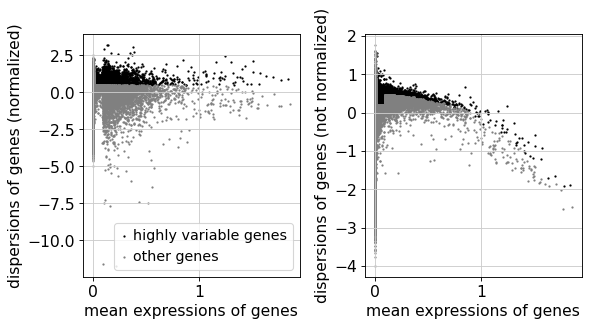

In [17]:
cellcycle_adata = adata.copy()
# Extract highly variable genes
filter_result = sc.pp.filter_genes_dispersion(
    cellcycle_adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result)

In [18]:
# Traspose matrix for a GENE-centered analysis
cellcycle_adata = cellcycle_adata.T
cellcycle_adata = cellcycle_adata[filter_result.gene_subset,:]

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [19]:
# Scale data to unit variance and zero mean
cellcycle_adata = cellcycle_adata.copy() # defeats an error with sc.pp.scale
sc.pp.scale(cellcycle_adata, max_value=10)
# Scatter plot in PCA coordinates
sc.tl.pca(cellcycle_adata, svd_solver='arpack')

computing PCA
    with n_comps=50
    finished (0:00:02)


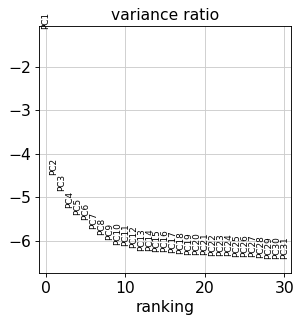

In [20]:
# Plot the variance ratio
sc.pl.pca_variance_ratio(cellcycle_adata, log=True)

In [21]:
# Identify genes behaving like cc genes
num_pcs = 10
# Compute a neighborhood graph of observations
sc.pp.neighbors(cellcycle_adata,n_pcs=num_pcs)
# Embed the neighborhood graph using UMAP
sc.tl.umap(cellcycle_adata)
cellcycle_adata.obs['known_cyclers'] = [i in ['CDK1','MKI67','CCNB2','PCNA'] for i in cellcycle_adata.obs_names]

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


In [22]:
cellcycle_adata.obs['known_cyclers_binary'] = [1 if elem else 0 for elem in cellcycle_adata.obs['known_cyclers']]

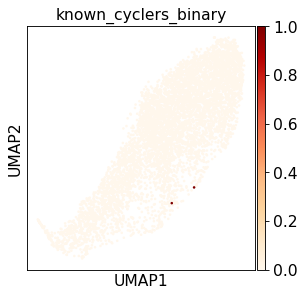

In [23]:
# Scatter plot in UMAP basis
sc.pl.umap(cellcycle_adata,color=['known_cyclers_binary'],color_map='OrRd',save='_ccg_identification.pdf')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 18 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


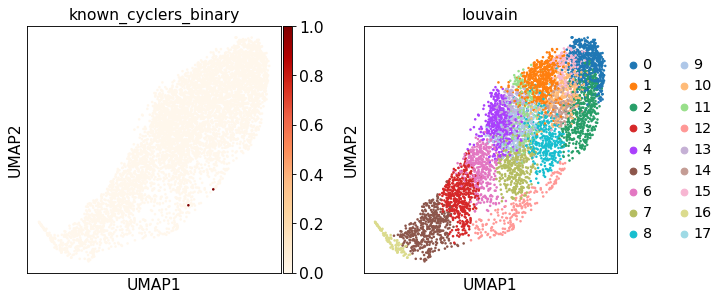

In [24]:
# Cluster GENES into subgroups using louvain: resolution < 1 to find less clusters
sc.tl.louvain(cellcycle_adata, resolution=1.9)
sc.pl.umap(cellcycle_adata,color=['known_cyclers_binary','louvain'],color_map='OrRd')

In [25]:
for gene in ['CDK1','MKI67','CCNB2','PCNA']:
    if gene in cellcycle_adata.obs.index:
        print(gene)

CCNB2
PCNA


In [26]:
# Locate genes of interests' cluster
print(cellcycle_adata.obs.loc[[#'CDK1','MKI67',
    'CCNB2','PCNA'],'louvain'])


CCNB2    12
PCNA     12
Name: louvain, dtype: category
Categories (18, object): ['0', '1', '2', '3', ..., '14', '15', '16', '17']


Removing cluster 12 of genes

In [27]:
# Add unstructured dict-like annotation for ccgs
adata.uns['ccgs'] = list(cellcycle_adata.obs[cellcycle_adata.obs['louvain']=='12'].index)
# Remove cc genes
adata = adata[:,[i not in adata.uns['ccgs'] for i in adata.var_names]]

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [28]:
adata

View of AnnData object with n_obs × n_vars = 1324 × 20839
    obs: 'batchcode', 'treatment', 'celltype', 'n_genes', 'lane', 'percent_mito', 'n_counts', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet'
    var: 'n_cells-0', 'n_cells-1', 'n_cells-2', 'n_cells-3'
    uns: 'ccgs'

## Subsetting to highly variable genes

In [29]:
%%time
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
Trying to set attribute `.uns` of view, copying.
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


CPU times: user 658 ms, sys: 80.8 ms, total: 739 ms
Wall time: 736 ms


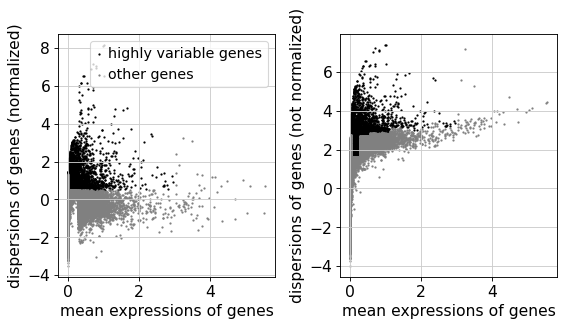

CPU times: user 649 ms, sys: 0 ns, total: 649 ms
Wall time: 647 ms


In [30]:
%%time
sc.pl.highly_variable_genes(adata)

In [31]:
adata_hvg = adata[:, adata.var['highly_variable']]

In [32]:
%%time
sc.pp.scale(adata_hvg, max_value=10)

/opt/conda/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


CPU times: user 142 ms, sys: 68.3 ms, total: 210 ms
Wall time: 209 ms


In [33]:
%%time
sc.tl.pca(adata_hvg, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


CPU times: user 12.2 s, sys: 11.7 s, total: 23.9 s
Wall time: 2.4 s


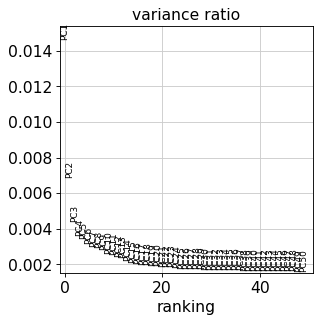

In [34]:
sc.pl.pca_variance_ratio(adata_hvg, n_pcs=50)

In [35]:
adata_hvg

AnnData object with n_obs × n_vars = 1324 × 6156
    obs: 'batchcode', 'treatment', 'celltype', 'n_genes', 'lane', 'percent_mito', 'n_counts', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet'
    var: 'n_cells-0', 'n_cells-1', 'n_cells-2', 'n_cells-3', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'ccgs', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

__________________________________________________________________________________________________________________________________________________________________

In [37]:
%%time
sc.pp.neighbors(adata_hvg, n_neighbors=10, n_pcs=15)

computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


CPU times: user 833 ms, sys: 1.8 s, total: 2.64 s
Wall time: 178 ms


__________________________________________________________________________________________________________________________________________________________________

In [38]:
%%time
sc.tl.umap(adata_hvg, random_state=0)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


CPU times: user 3.61 s, sys: 3.11 s, total: 6.72 s
Wall time: 2.75 s


## Clustering

In [39]:
sc.tl.louvain(adata_hvg, random_state=0)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


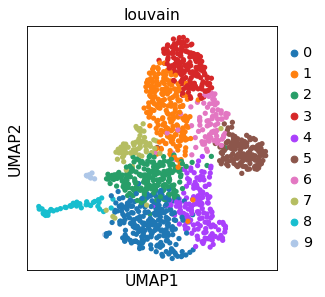

In [40]:
sc.pl.umap(adata_hvg, color=['louvain'])

At this point we are ready to run the 
### Second step of bertie doublet caller:

In [42]:
np.unique(adata_hvg.obs['is_doublet'])

array([False])

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


         is_doublet
louvain            
0             False
1             False
2             False
3             False
4             False
5             False
6             False
7             False
8             False
9             False


/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


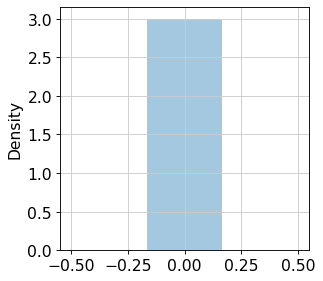

In [43]:
sc.tl.louvain(adata_hvg, random_state=0)
cluster_key = 'louvain'

doublet_counts = adata_hvg.obs.loc[:,['is_doublet', cluster_key]].groupby(cluster_key).mean()
#this can be printed for a summary of per-population doublet frequency...
print(doublet_counts)
#...or shown as a histogram for a potentially useful visualisation
sns.distplot(doublet_counts)

#the actual computation happens here
med = np.median(doublet_counts)
mask = doublet_counts.values>med
mad = np.median(doublet_counts.values[mask]-med)
pvals = 1-scipy.stats.norm.cdf(doublet_counts, loc=med, scale=1.4826*mad)
pvals_adj = bh(pvals)
doublet_populations = list(doublet_counts.index[pvals_adj<0.1])

#flag the entirety of the doublet populations as doublets
adata_hvg.obs['is_doublet_poptrim'] = adata.obs['is_doublet'].copy()
adata_hvg.obs.loc[[i in doublet_populations for i in adata_hvg.obs[cluster_key]],'is_doublet_poptrim'] = True

In [44]:
# binarising
adata_hvg.obs['is_doublet'] = [1 if elem else 0 for elem in adata_hvg.obs['is_doublet']]
adata_hvg.obs['is_doublet_poptrim'] = [1 if elem else 0 for elem in adata_hvg.obs['is_doublet_poptrim']]

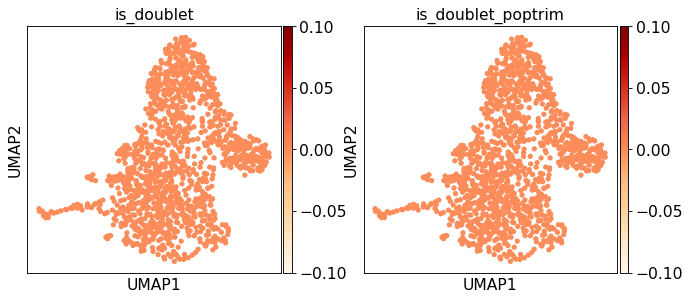

In [45]:
sc.pl.umap(adata_hvg, color=['is_doublet', 'is_doublet_poptrim'], cmap='OrRd')

In [46]:
adata_hvg.obs['cell_id'] = adata_hvg.obs.index

In [47]:
#def add_doublets(adata_obj, cell_id):
#    if adata_obj.obs.loc[cell_id,'is_doublet'] == 1:
#        return('Doublets')
#    else:
#        return(adata_obj.obs.loc[cell_id,'celltype'])


In [48]:
#adata_hvg.obs['celltype'] = adata_hvg.obs['cell_id'].apply(lambda x: add_doublets(adata_hvg,x))

In [49]:
# FINAL VERSION OF THE DATA
adata_hvg.write('/home/jovyan/notebooks/Vento_Lab/CVID/202009_new_analysis_revision/CITE_all_samples_analysis/CVID/202003_initial_analysis_scTranscriptomics/scTranscriptomics/adata_objects/adata_SS2_final_20210419.h5ad')

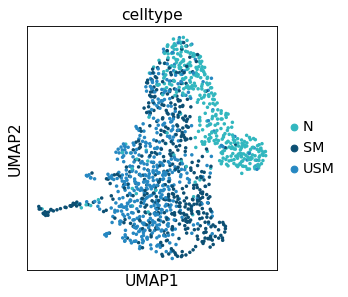

In [50]:
sc.pl.umap(adata_hvg, color='celltype', s=40, palette = [#'lightgrey',
    '#32b7bf',
                                                         '#0c4f73', '#2688c2'],
          save='_SS2_celltype.pdf')

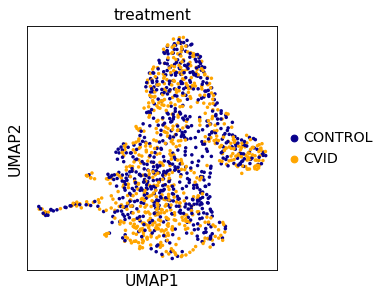

In [51]:
# figures for paper
sc.pl.umap(adata_hvg, color='treatment', s=40, palette = ['#08008c','#ffa500'],
          save='_SS2_condition.pdf')

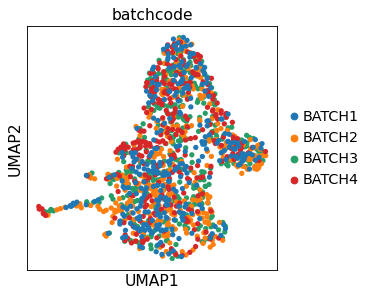

In [89]:
# also producing other important UMAPs - here only batchcode
sc.pl.umap(adata_hvg, color='batchcode', save='_SS2_batchcode.pdf')

## DE analysis with limma

In [52]:
adata

AnnData object with n_obs × n_vars = 1324 × 20839
    obs: 'batchcode', 'treatment', 'celltype', 'n_genes', 'lane', 'percent_mito', 'n_counts', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet'
    var: 'n_cells-0', 'n_cells-1', 'n_cells-2', 'n_cells-3', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'ccgs', 'hvg'

Here I'm going to do 3 cell type based CVID vs non-CVID comparisons

In [53]:
adata.obs['celltype_treatment'] = [i+'_'+j for i,j in zip(adata.obs['celltype'],adata.obs['treatment'])]

In [54]:
# creating also the full object (all genes) - only normalised and log transformed
adata_full = anndata.AnnData(X=adata.raw.X,
                            obs=adata.obs,
                            var=adata.raw.var,
                            obsm=adata.obsm)

In [55]:
# marker calling

#t = adata_hvg.X.toarray().T
t = adata_full.X.T
df = pd.DataFrame(data=t, columns= adata_full.obs.index, index=adata_full.var_names)

meta_df = pd.DataFrame(data={'Cell':list(adata_full.obs.index),
                             'cell_type':[ str(i) for i in adata_full.obs['celltype_treatment']],
                             'sample':[ str(i) for i in adata_full.obs['batch']]})
meta_df.set_index('Cell', inplace=True)

In [56]:
meta_df

,cell_type,sample
Cell,,
SCGC--2500_C02,N_CONTROL,0
SCGC--2499_C03,N_CONTROL,0
SCGC--2500_C03,N_CONTROL,0
SCGC--2499_C04,N_CONTROL,0
SCGC--2500_C04,N_CONTROL,0
...,...,...
SCGC--2513_B10,SM_CVID,3
SCGC--2510_B11,SM_CONTROL,3
SCGC--2502_C01,N_CVID,3


In [57]:
np.unique(meta_df['cell_type'], return_counts=True)

(array(['N_CONTROL', 'N_CVID', 'SM_CONTROL', 'SM_CVID', 'USM_CONTROL',
        'USM_CVID'], dtype=object),
 array([174, 203, 227, 226, 245, 249]))

In [58]:
%load_ext rpy2.ipython

In [59]:
outpath = './SS2_DE_limma/'

In [60]:
%%R
library(limma)
library(edgeR)

In [61]:
meta_df.reset_index(inplace=True)

In [62]:
meta_df

,Cell,cell_type,sample
0,SCGC--2500_C02,N_CONTROL,0
1,SCGC--2499_C03,N_CONTROL,0
2,SCGC--2500_C03,N_CONTROL,0
3,SCGC--2499_C04,N_CONTROL,0
4,SCGC--2500_C04,N_CONTROL,0
...,...,...,...
1319,SCGC--2513_B10,SM_CVID,3
1320,SCGC--2510_B11,SM_CONTROL,3
1321,SCGC--2502_C01,N_CVID,3
1322,SCGC--2502_C02,N_CVID,3


In [65]:
df

,SCGC--2500_C02,SCGC--2499_C03,SCGC--2500_C03,SCGC--2499_C04,SCGC--2500_C04,SCGC--2499_C05,SCGC--2500_C05,SCGC--2499_C06,SCGC--2500_C06,SCGC--2499_C07,...,SCGC--2513_B08,SCGC--2510_B09,SCGC--2509_A04,SCGC--2513_B09,SCGC--2510_B10,SCGC--2513_B10,SCGC--2510_B11,SCGC--2502_C01,SCGC--2502_C02,SCGC--2502_A05
A1BG,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
A1BG-AS1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
A1CF,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
A2M,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.032441,0.000000,0.000000,0.000000,0.0,0.000000
A2ML1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYX,0.0,0.0,0.0,0.000000,0.0,1.359927,1.093538,0.0,0.241758,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.265796,0.000000,0.0,0.000000
ZZEF1,0.0,0.0,0.0,2.825326,0.0,0.000000,0.000000,0.0,1.920055,0.0,...,1.130052,2.166849,0.0,0.0,0.000000,1.970487,1.888722,0.000000,0.0,0.425715
ZZZ3,0.0,0.0,0.0,0.000000,0.0,2.348922,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.872069,2.559245,0.0,0.000000
bP-21264C1.2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


In [66]:
# comparison groups
# done sequentially for Naive, US-mem and S-mem (CVID vs CONTROL)
case = 'SM_CVID'
ctrl = 'SM_CONTROL'

In [67]:
%%R -i df -i meta_df -i outpath -i ctrl -i case 

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# subset meta
meta_df = subset(meta_df, cell_type %in% unlist(c(ctrl, case)) )
print(unique(meta_df$cell_type))

# Shared cells
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter lowly expressed genes
keep = rowSums(ex_mat, na.rm=T) > 0.1
ex_mat = ex_mat[ keep, ]
keep = aveLogCPM(ex_mat) > 0.1
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
celltypes = unique(meta_df$cell_type)

# Extract cells in cluster and rest
cells_case = rownames(subset(meta_df, cell_type == case))
cells_ctrl = rownames(subset(meta_df, cell_type == ctrl)) # changed from control to ctrl

# build cluster_type vector
cluster_type = rep(0, length(cells))
names(cluster_type) = cells
cluster_type[ cells_case ] = 'case'
cluster_type[ cells_ctrl ] = 'ctrl'

print(unique(cluster_type))

design.matrix <- model.matrix(~ 0 + cluster_type)

# Now tell limma how do you want to compare (i.e. case vs control)
contrast.matrix <- makeContrasts(caseVScontrol = cluster_typecase - cluster_typectrl, levels = design.matrix)

# Make model and run contrasts
fit <- lmFit(ex_mat, design.matrix)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)

# Make a dataframe containing the important data
results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'caseVScontrol')

# Add and filter needed data
results$Gene = rownames(results)
results = results[ , c('Gene', 'logFC', 'P.Value', 'adj.P.Val')]
results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, mean)
results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, mean)
results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_case], 1, function(x) sum(c(x > 0)+0) ) / length(cells_case)
results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_ctrl], 1, function(x) sum(c(x > 0)+0) ) / length(cells_ctrl)

results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
results$AveExpr_rest = round(results$AveExpr_rest, 6)
results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
results$percentExpr_rest = round(results$percentExpr_rest, 6)
# and store it as csv file
write.csv(results, file = paste0(outpath, case, '_vs_', ctrl, '_limma_DEGs_20210419.csv'), row.names = F, col.names = T, quote = F)

[1] "SM_CONTROL" "SM_CVID"   


R[write to console]: 453 shared cells



[1] "ctrl" "case"


In [68]:
adata_hvg

AnnData object with n_obs × n_vars = 1324 × 6156
    obs: 'batchcode', 'treatment', 'celltype', 'n_genes', 'lane', 'percent_mito', 'n_counts', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'louvain', 'is_doublet_poptrim', 'cell_id'
    var: 'n_cells-0', 'n_cells-1', 'n_cells-2', 'n_cells-3', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'ccgs', 'hvg', 'pca', 'neighbors', 'umap', 'louvain', 'louvain_colors', 'celltype_colors', 'treatment_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### Saving the object for cellxgene

In [69]:
adata_hvg

AnnData object with n_obs × n_vars = 1324 × 6156
    obs: 'batchcode', 'treatment', 'celltype', 'n_genes', 'lane', 'percent_mito', 'n_counts', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'louvain', 'is_doublet_poptrim', 'cell_id'
    var: 'n_cells-0', 'n_cells-1', 'n_cells-2', 'n_cells-3', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'ccgs', 'hvg', 'pca', 'neighbors', 'umap', 'louvain', 'louvain_colors', 'celltype_colors', 'treatment_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [70]:
adata_full = anndata.AnnData(X=adata_hvg.raw.X,
                            obs=adata_hvg.obs,
                            var=adata_hvg.raw.var,
                            obsm=adata_hvg.obsm)

In [71]:
adata_full

AnnData object with n_obs × n_vars = 1324 × 21030
    obs: 'batchcode', 'treatment', 'celltype', 'n_genes', 'lane', 'percent_mito', 'n_counts', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'louvain', 'is_doublet_poptrim', 'cell_id'
    var: 'n_cells-0', 'n_cells-1', 'n_cells-2', 'n_cells-3'
    obsm: 'X_pca', 'X_umap'

In [72]:
adata_full.obs

,batchcode,treatment,celltype,n_genes,lane,percent_mito,n_counts,scrublet_score,scrublet_cluster_score,bh_pval,batch,is_doublet,louvain,is_doublet_poptrim,cell_id
SCGC--2500_C02,BATCH3,CONTROL,N,1264,24057_6,0.039233,18199.0,0.095477,0.095477,0.975326,0,0,5,0,SCGC--2500_C02
SCGC--2499_C03,BATCH3,CONTROL,N,877,24057_6,0.080071,14000.0,0.028409,0.095477,0.975326,0,0,6,0,SCGC--2499_C03
SCGC--2500_C03,BATCH3,CONTROL,N,1786,24057_6,0.054565,131017.0,0.257732,0.210526,0.808411,0,0,5,0,SCGC--2500_C03
SCGC--2499_C04,BATCH3,CONTROL,N,394,24057_6,0.081609,14496.0,0.064000,0.083333,0.975326,0,0,1,0,SCGC--2499_C04
SCGC--2500_C04,BATCH3,CONTROL,N,544,24057_6,0.099694,14364.0,0.109890,0.095477,0.975326,0,0,3,0,SCGC--2500_C04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SCGC--2513_B10,BATCH1,CVID,SM,2177,24130_7,0.053583,385477.0,0.175573,0.234129,0.755951,3,0,0,0,SCGC--2513_B10
SCGC--2510_B11,BATCH1,CONTROL,SM,1805,24130_7,0.056122,229909.0,0.210526,0.234129,0.755951,3,0,1,0,SCGC--2510_B11
SCGC--2502_C01,BATCH1,CVID,N,303,24130_7,0.072749,1677.0,0.056180,0.056180,0.915471,3,0,3,0,SCGC--2502_C01
SCGC--2502_C02,BATCH1,CVID,N,521,24130_7,0.085348,3351.0,0.032836,0.064000,0.915471,3,0,3,0,SCGC--2502_C02


In [73]:
#adata_full.obs.columns = ['batch', 'batchcode', 'bh_pval', 'celltype', 'lane', 'n_counts',
#       'n_genes', 'percent_mito', 'scrublet_cluster_score', 'scrublet_score',
#       'condition', # changing this from treatment
#                          'is_doublet', 'louvain', 
#                          'is_doublet_propagate', # changing this from is_doublet_poptrim
#                          'cell_id']

In [74]:
adata_full

AnnData object with n_obs × n_vars = 1324 × 21030
    obs: 'batchcode', 'treatment', 'celltype', 'n_genes', 'lane', 'percent_mito', 'n_counts', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'louvain', 'is_doublet_poptrim', 'cell_id'
    var: 'n_cells-0', 'n_cells-1', 'n_cells-2', 'n_cells-3'
    obsm: 'X_pca', 'X_umap'

In [75]:
import scipy
adata_full.X = scipy.sparse.csc_matrix(adata_full.X)


In [82]:
categ_columns = ['batch', 'batchcode', 'celltype', 'lane', 
                 'treatment', 'is_doublet',
                 'cell_id']

cont_columns = ['bh_pval', 'n_counts', 'n_genes', 'percent_mito', 'scrublet_cluster_score', 
                'scrublet_score']


In [83]:
adata_full.obs

,batchcode,treatment,celltype,n_genes,lane,percent_mito,n_counts,scrublet_score,scrublet_cluster_score,bh_pval,batch,is_doublet,louvain,is_doublet_poptrim,cell_id
SCGC--2500_C02,BATCH3,CONTROL,N,1264,24057_6,0.039233,18199.0,0.095477,0.095477,0.975326,0,0,5,0,SCGC--2500_C02
SCGC--2499_C03,BATCH3,CONTROL,N,877,24057_6,0.080071,14000.0,0.028409,0.095477,0.975326,0,0,6,0,SCGC--2499_C03
SCGC--2500_C03,BATCH3,CONTROL,N,1786,24057_6,0.054565,131017.0,0.257732,0.210526,0.808411,0,0,5,0,SCGC--2500_C03
SCGC--2499_C04,BATCH3,CONTROL,N,394,24057_6,0.081609,14496.0,0.064000,0.083333,0.975326,0,0,1,0,SCGC--2499_C04
SCGC--2500_C04,BATCH3,CONTROL,N,544,24057_6,0.099694,14364.0,0.109890,0.095477,0.975326,0,0,3,0,SCGC--2500_C04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SCGC--2513_B10,BATCH1,CVID,SM,2177,24130_7,0.053583,385477.0,0.175573,0.234129,0.755951,3,0,0,0,SCGC--2513_B10
SCGC--2510_B11,BATCH1,CONTROL,SM,1805,24130_7,0.056122,229909.0,0.210526,0.234129,0.755951,3,0,1,0,SCGC--2510_B11
SCGC--2502_C01,BATCH1,CVID,N,303,24130_7,0.072749,1677.0,0.056180,0.056180,0.915471,3,0,3,0,SCGC--2502_C01
SCGC--2502_C02,BATCH1,CVID,N,521,24130_7,0.085348,3351.0,0.032836,0.064000,0.915471,3,0,3,0,SCGC--2502_C02


In [84]:
import pandas
for column in categ_columns:
    adata_full.obs[column] = pd.Categorical(adata_full.obs[column])
    
for column in cont_columns:
    print(column)
    adata_full.obs[column] = np.float32(adata_full.obs[column])

bh_pval
n_counts
n_genes
percent_mito
scrublet_cluster_score
scrublet_score


In [85]:
adata_full.write('/home/jovyan/notebooks/Vento_Lab/CVID/202009_new_analysis_revision/CITE_all_samples_analysis/CVID/202003_initial_analysis_scTranscriptomics/scTranscriptomics/adata_objects/adata_SS2_for_cellxgene_20210419.h5ad')